In [ ]:
pip install -U scikit-fuzzy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install anfis

In [ ]:
from skfuzzy import gaussmf, gbellmf, sigmf

#Class memfuncs
class MemFuncs:
    funcDict = {'gaussmf': gaussmf, 'gbellmf': gbellmf, 'sigmf': sigmf}

    #fungsi init
    def __init__(self, MFList):
        self.MFList = MFList

    #fungsi evaluateMF
    def evaluateMF(self, rowInput):
        if len(rowInput) != len(self.MFList):
            print("Number of variables does not match number of rule sets")

        return [[self.funcDict[self.MFList[i][k][0]](rowInput[i],**self.MFList[i][k][1]) for k in range(len(self.MFList[i]))] for i in range(len(rowInput))]

In [ ]:
import numpy as np

#fungsi partial_dMF
#menghitung turunan dari fungsi keanggotaan fuzzy pada sebuah input X
def partial_dMF(x, mf_definition, partial_parameter):
  mf_name = mf_definition[0]

  #menghitung turunan dari fungsi gaussian dengan parameter input sigma dan mean
  if mf_name == 'gaussmf':
    sigma = mf_definition[1]['sigma']
    mean = mf_definition[1]['mean']
    if partial_parameter == 'sigma':
      result = (2./sigma**3) * np.exp(-(((x-mean)**2)/(sigma)**2))*(x-mean)**2
    elif partial_parameter == 'mean':
      result = (2./sigma**2) * np.exp(-(((x-mean)**2)/(sigma)**2))*(x-mean)
  #menghitung turunan dari fungsi gbell dengan parameter input :a,b,c
  elif mf_name == 'gbellmf':
    a = mf_definition[1]['a']
    b = mf_definition[1]['b']
    c = mf_definition[1]['c']
    if partial_parameter == 'a':
      result = (2. * b * np.power((c-x),2) * np.power(np.absolute((c-x)/a), ((2 * b) - 2))) / \
      (np.power(a, 3) * np.power((np.power(np.absolute((c-x)/a),(2*b)) + 1), 2))
    elif partial_parameter == 'b':
      if (c-x)!=0:
        result = -1 * (2 * np.power(np.absolute((c-x)/a), (2 * b)) * np.log(np.absolute((c-x)/a))) / \
        (np.power((np.power(np.absolute((c-x)/a), (2 * b)) + 1), 2))
      else:
        result=0
    elif partial_parameter == 'c':
      if (c-x)!=0:
        result = (2. * b * (c-x) * np.power(np.absolute((c-x)/a), ((2 * b) - 2))) / \
        (np.power(a, 2) * np.power((np.power(np.absolute((c-x)/a),(2*b)) + 1), 2))
      else:
        result=0
  #menghitung turunan dari fungsi sigmoid dengan parameter input : b,c
  elif mf_name == 'sigmf':
    b = mf_definition[1]['b']
    c = mf_definition[1]['c']
    if partial_parameter == 'b':
      result = -1 * (c * np.exp(c * (b + x))) / \
      np.power((np.exp(b*c) + np.exp(c*x)), 2)
    elif partial_parameter == 'c':
      result = ((x - b) * np.exp(c * (x - b))) / \
      np.power((np.exp(c * (x - c))) + 1, 2)
  return result




In [ ]:
#class ANFIS
#X : input data training
#Y : output data training
#XLen : banyaknya data training
#memClass : class membership function
#memFuncs : membership function
#memFuncsByVariable : membership function untuk setiap variabel
#rules : menunjukkan rule yang digunakan (1 mf, 1 rule)
#consequents : parameter pada bagian consequent
#errors : error hasil prediksi

class ANFIS:
    #fungsi init
    #inisialisasi
    def __init__(self, X, Y, memFunction):
        self.X = np.array(copy.copy(X))
        self.Y = np.array(copy.copy(Y))
        self.XLen = len(self.X)
        self.memClass = copy.deepcopy(memFunction)
        self.memFuncs = self.memClass.MFList
        self.memFuncsByVariable = [[x for x in range(len(self.memFuncs[z]))] for z in range(len(self.memFuncs))]
        self.rules = np.array(list(itertools.product(*self.memFuncsByVariable)))
        self.consequents = np.empty(self.Y.ndim * len(self.rules) * (self.X.shape[1] + 1))
        self.consequents.fill(0)
        self.errors = np.empty(0)
        self.memFuncsHomo = all(len(i)==len(self.memFuncsByVariable[0]) for i in self.memFuncsByVariable)
        self.trainingType = 'Not trained yet'

    #fungsi LSE
    def LSE(self, A, B, initialGamma = 1000.):
        coeffMat = A
        rhsMat = B
        S = np.eye(coeffMat.shape[1])*initialGamma
        x = np.zeros((coeffMat.shape[1],1))
        for i in range(len(coeffMat[:,0])):
            a = coeffMat[i,:]
            b = np.array(rhsMat[i])
            S = S - (np.array(np.dot(np.dot(np.dot(S,np.matrix(a).transpose()),np.matrix(a)),S)))/(1+(np.dot(np.dot(S,a),a)))
            x = x + (np.dot(S,np.dot(np.matrix(a).transpose(),(np.matrix(b)-np.dot(np.matrix(a),x)))))
        return x

    #fungsi training hybrid
    def trainHybridJangOffLine(self, epochs=5, tolerance=1e-5, initialGamma=1000, k=0.01):

        self.trainingType = 'trainHybridJangOffLine'
        convergence = False
        epoch = 1

        #Mulai proses looping : Menghitung luaran dan komputasi LSE
        while (epoch < epochs) and (convergence is not True):

            #layer four: forward pass
            [layerFour, wSum, w] = forwardHalfPass(self, self.X)

            #layer five: least squares estimate
            layerFive = np.array(self.LSE(layerFour,self.Y,initialGamma))
            self.consequents = layerFive
            layerFive = np.dot(layerFour,layerFive)

            #error
            #Menghitung error pada layer 5 dan mengecek kondisi konvergen
            error = np.sum((self.Y-layerFive.T)**2)
            print('current error: '+ str(error))
            average_error = np.average(np.absolute(self.Y-layerFive.T))
            self.errors = np.append(self.errors,error)

            if len(self.errors) != 0:
                if self.errors[len(self.errors)-1] < tolerance:
                    convergence = True

            # back propagation : menghitung error ke depan mulai layer 3
            if convergence is not True:
                cols = range(len(self.X[0,:]))
                dE_dAlpha = list(backprop(self, colX, cols, wSum, w, layerFive) for colX in range(self.X.shape[1]))


            if len(self.errors) >= 4:
                if (self.errors[-4] > self.errors[-3] > self.errors[-2] > self.errors[-1]):
                    k = k * 1.1

            if len(self.errors) >= 5:
                if (self.errors[-1] < self.errors[-2]) and (self.errors[-3] < self.errors[-2]) and (self.errors[-3] < self.errors[-4]) and (self.errors[-5] > self.errors[-4]):
                    k = k * 0.9

            ## handling of variables with a different number of MFs
            #Menangani variable input dengan jumlah fungsi keanggotaan yang berbeda
            t = []
            for x in range(len(dE_dAlpha)):
                for y in range(len(dE_dAlpha[x])):
                    for z in range(len(dE_dAlpha[x][y])):
                        t.append(dE_dAlpha[x][y][z])

            eta = k / np.abs(np.sum(t))

            if(np.isinf(eta)):
                eta = k

            dAlpha = copy.deepcopy(dE_dAlpha)
            if not(self.memFuncsHomo):
                for x in range(len(dE_dAlpha)):
                    for y in range(len(dE_dAlpha[x])):
                        for z in range(len(dE_dAlpha[x][y])):
                            dAlpha[x][y][z] = -eta * dE_dAlpha[x][y][z]
            else:
                dAlpha = -eta * np.array(dE_dAlpha)


            #Mengupdate parameter dan menghitung luaran baru
            for varsWithMemFuncs in range(len(self.memFuncs)):
                for MFs in range(len(self.memFuncsByVariable[varsWithMemFuncs])):
                    paramList = sorted(self.memFuncs[varsWithMemFuncs][MFs][1])
                    for param in range(len(paramList)):
                        self.memFuncs[varsWithMemFuncs][MFs][1][paramList[param]] = self.memFuncs[varsWithMemFuncs][MFs][1][paramList[param]] + dAlpha[varsWithMemFuncs][MFs][param]
            epoch = epoch + 1


        self.fittedValues = predict(self,self.X)
        self.residuals = self.Y - self.fittedValues[:,0]

        return self.fittedValues

    #fungsi plot error
    def plotErrors(self):
        if self.trainingType == 'Not trained yet':
            print(self.trainingType)
        else:
            import matplotlib.pyplot as plt
            plt.plot(range(len(self.errors)),self.errors,'ro', label='errors')
            plt.ylabel('error')
            plt.xlabel('epoch')
            plt.show()

    #fungsi plot membership function
    def plotMF(self, x, inputVar):
        import matplotlib.pyplot as plt
        from skfuzzy import gaussmf, gbellmf, sigmf

        for mf in range(len(self.memFuncs[inputVar])):
            if self.memFuncs[inputVar][mf][0] == 'gaussmf':
                y = gaussmf(x,**self.memClass.MFList[inputVar][mf][1])
            elif self.memFuncs[inputVar][mf][0] == 'gbellmf':
                y = gbellmf(x,**self.memClass.MFList[inputVar][mf][1])
            elif self.memFuncs[inputVar][mf][0] == 'sigmf':
                y = sigmf(x,**self.memClass.MFList[inputVar][mf][1])

            plt.plot(x,y,'r')

        plt.show()

    #fungsi plot result
    def plotResults(self):
        if self.trainingType == 'Not trained yet':
            print(self.trainingType)
        else:
            import matplotlib.pyplot as plt
            plt.plot(range(len(self.fittedValues)),self.fittedValues,'r', label='trained')
            plt.plot(range(len(self.Y)),self.Y,'b', label='original')
            plt.legend(loc='upper left')
            plt.show()


In [ ]:
#fungsi forward
#digunakan untuk mendapatkan luaran tiap layer sampai layer ke-empat
def forwardHalfPass(ANFISObj, Xs):
    layerFour = np.empty(0,)
    wSum = []

    #Mulai looping dan perhitungan di layer 1 :
    for pattern in range(len(Xs[:,0])):
        #layer one
        layerOne = ANFISObj.memClass.evaluateMF(Xs[pattern,:])

        #Perhitungan di layer 2:
        #layer two
        miAlloc = [[layerOne[x][ANFISObj.rules[row][x]] for x in range(len(ANFISObj.rules[0]))] for row in range(len(ANFISObj.rules))]
        layerTwo = np.array([np.product(x) for x in miAlloc]).T
        if pattern == 0:
            w = layerTwo
        else:
            w = np.vstack((w,layerTwo))

        #Perhitungan di layer 3:
        #layer three
        wSum.append(np.sum(layerTwo))
        if pattern == 0:
            wNormalized = layerTwo/wSum[pattern]
        else:
            wNormalized = np.vstack((wNormalized,layerTwo/wSum[pattern]))

        #Perhitungan di layer 4:
        #prep for layer four (bit of a hack)
        layerThree = layerTwo/wSum[pattern]
        rowHolder = np.concatenate([x*np.append(Xs[pattern,:],1) for x in layerThree])
        layerFour = np.append(layerFour,rowHolder)

    #Return nilai layer 4 (setelah looping):
    w = w.T
    wNormalized = wNormalized.T

    layerFour = np.array(np.array_split(layerFour,pattern + 1))

    return layerFour, wSum, w

In [ ]:
#fungsi backward pass
#fungsi yang digunakan untuk mengupdate parameter pada fungsi keanggotaan dengan langkah kebelakang
def backprop(ANFISObj, columnX, columns, theWSum, theW, theLayerFive):

    paramGrp = [0]* len(ANFISObj.memFuncs[columnX])
    #Untuk semua fungsi keanggotaan:
    for MF in range(len(ANFISObj.memFuncs[columnX])):
        parameters = np.empty(len(ANFISObj.memFuncs[columnX][MF][1]))
        timesThru = 0
        #Untuk semua parameter pada fungsi ke anggotaan ke-MF, dan untuk semua baris dari parameter
        for alpha in sorted(ANFISObj.memFuncs[columnX][MF][1].keys()):

            bucket3 = np.empty(len(ANFISObj.X))
            for rowX in range(len(ANFISObj.X)):
                varToTest = ANFISObj.X[rowX,columnX]
                tmpRow = np.empty(len(ANFISObj.memFuncs))
                tmpRow.fill(varToTest)

                bucket2 = np.empty(ANFISObj.Y.ndim)

                #Untuk semua kolom pada baris terpilih, hitung delta alpha (besarnya perubahan setiap parameter)
                for colY in range(ANFISObj.Y.ndim):

                    rulesWithAlpha = np.array(np.where(ANFISObj.rules[:,columnX]==MF))[0]
                    adjCols = np.delete(columns,columnX)

                    senSit = partial_dMF(ANFISObj.X[rowX,columnX],ANFISObj.memFuncs[columnX][MF],alpha)
                    # produces d_ruleOutput/d_parameterWithinMF
                    dW_dAplha = senSit * np.array([np.prod([ANFISObj.memClass.evaluateMF(tmpRow)[c][ANFISObj.rules[r][c]] for c in adjCols]) for r in rulesWithAlpha])

                    bucket1 = np.empty(len(ANFISObj.rules[:,0]))

                    #Untuk semua fungsi konsekuen hitung hasil fungsi nya
                    for consequent in range(len(ANFISObj.rules[:,0])):
                        fConsequent = np.dot(np.append(ANFISObj.X[rowX,:],1.),ANFISObj.consequents[((ANFISObj.X.shape[1] + 1) * consequent):(((ANFISObj.X.shape[1] + 1) * consequent) + (ANFISObj.X.shape[1] + 1)),colY])
                        acum = 0
                        if consequent in rulesWithAlpha:
                            acum = dW_dAplha[np.where(rulesWithAlpha==consequent)] * theWSum[rowX]

                        acum = acum - theW[consequent,rowX] * np.sum(dW_dAplha)
                        acum = acum / theWSum[rowX]**2
                        bucket1[consequent] = fConsequent * acum

                    #Hitung akumulasi untuk setiap looping dan kembalikan nilai parameter terakhir
                    sum1 = np.sum(bucket1)

                    if ANFISObj.Y.ndim == 1:
                        bucket2[colY] = sum1 * (ANFISObj.Y[rowX]-theLayerFive[rowX,colY])*(-2)
                    else:
                        bucket2[colY] = sum1 * (ANFISObj.Y[rowX,colY]-theLayerFive[rowX,colY])*(-2)

                sum2 = np.sum(bucket2)
                bucket3[rowX] = sum2

            sum3 = np.sum(bucket3)
            parameters[timesThru] = sum3
            timesThru = timesThru + 1

        paramGrp[MF] = parameters

    return paramGrp

In [ ]:
#fungsi predict
#Fungsi ini digunakan untuk memprediksi atau mendapatkan nilai luaran pada layer kelima
def predict(ANFISObj, varsToTest):

    [layerFour, wSum, w] = forwardHalfPass(ANFISObj, varsToTest)

    #layer five
    layerFive = np.dot(layerFour,ANFISObj.consequents)

    return layerFive

In [ ]:
#import library
import numpy as np
import copy
import itertools

#load txt
ts = np.loadtxt('/content/drive/My Drive/Colab Notebooks/trainingSet2.txt', usecols=[1,2,3])
X = ts[:,0:2]
Y = ts[:,2]

#Definisikan fungsi keanggotaan mula-mula dan komputasi setiap fungsi keanggotaan
mf = [[['gbellmf',{'a':3.,'b':2.,'c':0.}], ['gbellmf',{'a':3.,'b':2.,'c':10.}]],
      [['gbellmf',{'a':2.,'b':3.,'c':0.}], ['gbellmf',{'a':2.,'b' :3.,'c':10.}]]]
mfc = MemFuncs(mf)


current error: 3345.5996994969114
current error: 3345.14512503469
current error: 3344.6937164306923
current error: 3344.2454662224236
current error: 3343.7558224769436
current error: 3343.2213577040616
current error: 3342.638447902624
current error: 3342.0032824028167
current error: 3341.311880431467
current error: 3340.560116112196
current error: 3339.74375394381
current error: 3338.8584971748087
current error: 3337.900051924184
current error: 3336.864210375824
current error: 3335.7469569035266
current error: 3334.544601561916
current error: 3333.253946000894
current error: 3331.872487519745
current error: 3330.398667669035
current error: 3328.832172523365
current error: 3327.1742924877603
current error: 3325.428350270045
current error: 3323.6002064617105
current error: 3321.6988530602107
current error: 3319.737106269865
current error: 3317.7324110954673
current error: 3315.7077716175654
current error: 3313.692822390117
current error: 3311.72505795294
current error: 3309.851238539173


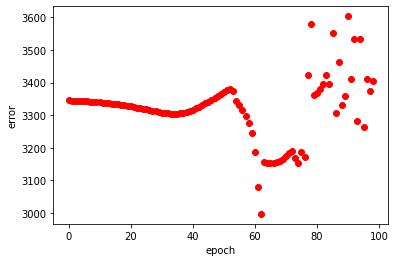

Plotting results


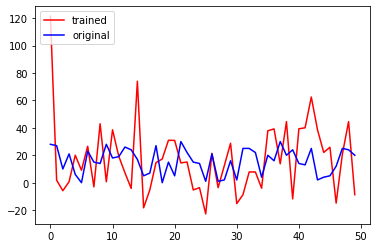

In [ ]:
# Definisikan ANFIS dan jalankan proses training
anf = ANFIS(X, Y, mfc)
anf.trainHybridJangOffLine(epochs=100)
print("Plotting errors")
anf.plotErrors()
print("Plotting results")
anf.plotResults()

In [ ]:
#prediksi luaran sistem, input 2 dan 2
z=predict(anf, np.array([[2., 2.]]))
z

array([[39.3138184]])

In [ ]:
#prediksi luaran sistem, input 52 dan 52
z=predict(anf, np.array([[52., 52.]]))
z

array([[-8.77428228]])

In [ ]:
#fungsi keanggotaan baru yang diperoleh dari hasil pembelajaran ANFIS
anf.memFuncs

[[['gbellmf',
   {'a': 5.2344419394301385,
    'b': -0.3005466773067421,
    'c': -0.47281351312573394}],
  ['gbellmf',
   {'a': 7.798857847949566, 'b': 4.139105007234189, 'c': 8.280606574873897}]],
 [['gbellmf',
   {'a': 5.697304679785723, 'b': 4.668961042197945, 'c': -4.6657085544255965}],
  ['gbellmf',
   {'a': 0.5230912831579038, 'b': 3.72971655933794, 'c': 10.03797479654563}]]]

In [ ]:
#parameter consequent untuk rule
anf.consequents

array([[ 19.97529648],
       [ -1.57200003],
       [261.31832693],
       [ -6.35902714],
       [ 60.56621478],
       [ 28.31270376],
       [-28.19621759],
       [  1.77872573],
       [-25.35309812],
       [-38.4685395 ],
       [-12.53923279],
       [ 33.11341391]])

In [ ]:
#perhitungan error hasil prediksi
import math
cons_new = anf.consequents
MSE = np.square(np.subtract(cons_new,z)).mean()
RMSE = math.sqrt(MSE)
print("RMSE:",RMSE)

RMSE: 83.38252652922749
